In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata
import os
import seaborn as sb
import matplotlib
from harmony import harmonize

In [2]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

/tmp/ipykernel_3678200/2253401465.py:13: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [3]:
adata_all = sc.read_h5ad("Big-atlas-counts-corrected2-ensembl-noCITE.h5ad") # not ensembleids. .X is rounded_corrected_counts (atlas) and counts for bashore

In [4]:
cite_adata = sc.read_h5ad("tmp/Bashore_onlyCITE.h5ad")

In [7]:
def normalize_subset_first(adata, cell_types):
    if isinstance(cell_types, list):
        adata_1 = adata[adata.obs["cell_type_level1"].isin(cell_types)]
    else:
        adata_1 = adata[adata.obs["cell_type_level1"] == cell_types]
    
    adata_pp = adata_1.copy()
    sc.pp.normalize_total(adata_pp, target_sum=1e6)
    sc.pp.log1p(adata_pp)
    sc.pp.pca(adata_pp, svd_solver="arpack")
    sc.pp.neighbors(adata_pp, n_pcs=30)
    sc.tl.leiden(adata_pp, key_added='groups', resolution=0.22)
    
    # Preprocess variables for scran normalization
    input_groups = adata_pp.obs['groups']
    data_mat = adata_1.X.T.toarray()
    del adata_pp
    
    return input_groups, data_mat, adata_1

In [8]:
def normalize_subset_second(adata_1, size_factors):
    adata_1.obs['size_factors'] = size_factors

    #Normalize adata 
    adata_1.X /= adata_1.obs['size_factors'].values[:,None]
    sc.pp.log1p(adata_1)
    # high variable genes selection
    sc.pp.highly_variable_genes(adata_1, n_top_genes=2000, subset=False)
    sc.pp.pca(adata_1, svd_solver="arpack", use_highly_variable=True)
    return adata_1

In [9]:
def subset_and_transfer_leiden(adata, cite_adata):
    # Find common barcodes between adata and cite_adata
    common_barcodes = adata.obs_names.intersection(cite_adata.obs_names)
    
    # Subset cite_adata to only the common barcodes
    cite_adata = cite_adata[common_barcodes].copy()
    
    # Transfer the 'leiden' labels from adata to cite_adata
    cite_adata.obs['leiden'] = adata.obs.loc[cite_adata.obs_names, 'leiden'].values
    
    # Ensure that there are no NaN values in the 'leiden' column
    assert not cite_adata.obs['leiden'].isnull().any(), "Some 'leiden' labels are NaN."
    
    # Return the updated cite_adata
    return cite_adata

# ECs

In [10]:
input_groups, data_mat, adata_out = normalize_subset_first(adata_all, "EC")

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOr

In [12]:
adata_ec = normalize_subset_second(adata_out, size_factors)

/tmp/ipykernel_3678200/2282018356.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_1.obs['size_factors'] = size_factors
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [13]:
adata_ec.obsm["Harmony"] = harmonize(adata_ec.obsm["X_pca"], adata_ec.obs, batch_key="dataset")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
Reach convergence after 2 iteration(s).


In [14]:
adata_ec.write("LarsJessi_ec_harm.h5ad")

In [15]:
sc.pp.neighbors(adata_ec, use_rep="Harmony")
sc.tl.umap(adata_ec)

In [16]:
sc.tl.leiden(adata_ec, resolution = 0.1)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_ac

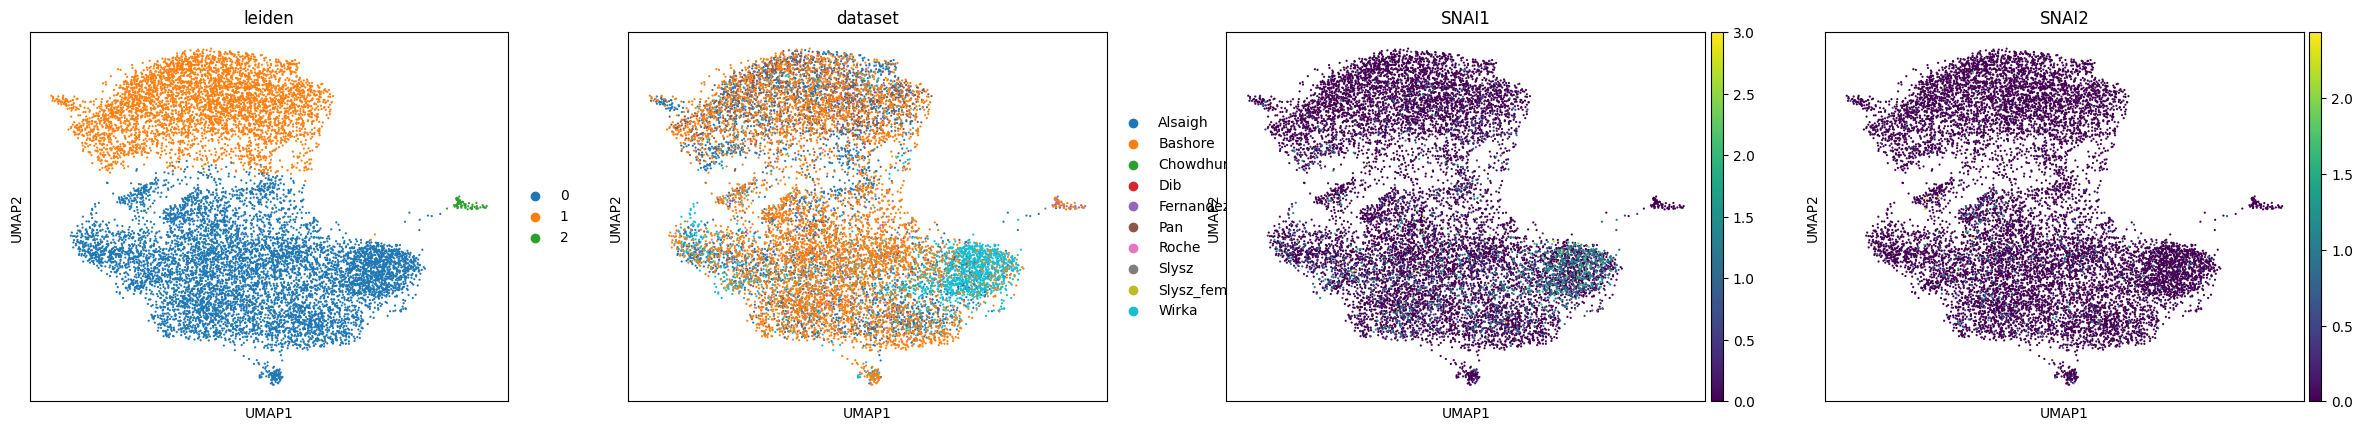

In [17]:
sc.pl.umap(adata_ec, color= ['leiden', "dataset", "SNAI1", "SNAI2"])

In [12]:
ec_subtypes = {
    #"Initmal": ["RAMP2"],
    "Proangiogenic": ["ACKR1", "AQP1", "FABP4", "CXCL12"],
    "EndoMT": ["COL1A2", "FN1", "ACTA2", "SNAI1", "SNAI2"],
    #"Lymphatic": ["LYVE1", "CCL21"], 

    
    #"Angiogenic": ["ACKR1"],
    #"Intimal / EndoMT-like": ["EGR1"],


    "Arterial ECs": ["GJ4", "GJ5", "GATA2", "MECOM", "GJA4", "GJA5"],
    "Venous ECs": ["ACKR1", "NR2F2"]
}

level2_marker = {
    "ECs": ec_subtypes
}

marker_genes_in_data = {}
for celltype in level2_marker["ECs"]:
    marker_genes_in_data[celltype] = list(set(level2_marker["ECs"][celltype]).intersection(adata_ec.var_names))
    print(celltype, len(set(level2_marker["ECs"][celltype]).intersection(adata_ec.var_names))/len(level2_marker["ECs"][celltype]))
    print("not included: ", set(level2_marker["ECs"][celltype]).difference(adata_ec.var_names))

Proangiogenic 1.0
not included:  set()
EndoMT 1.0
not included:  set()
Arterial ECs 0.6666666666666666
not included:  {'GJ4', 'GJ5'}
Venous ECs 1.0
not included:  set()


/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No dat

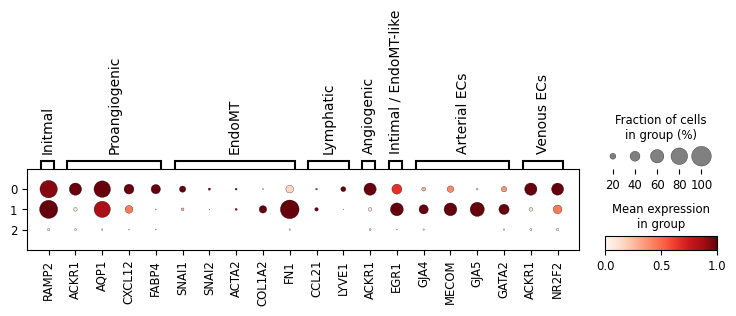

In [19]:
sc.pl.dotplot(
    adata_ec,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [ ]:
#0: pro angiogenic: venous origin
#1: endoMT: arterial origin
#rebuttal snail1 snail2

In [77]:
cite_ec = subset_and_transfer_leiden(adata_ec, cite_adata)

In [89]:
ec_subtypes_cite = {
    "Initmal": ["CD31", "VEGFR-3_FLT-4","CD309_VEGFR2","Annexin_A1","Notch3"], 
}

level2_marker_cite = {
    "ECs": ec_subtypes_cite
}

marker_genes_in_data_cite = {}
for celltype in level2_marker_cite["ECs"]:
    marker_genes_in_data_cite[celltype] = list(set(level2_marker_cite["ECs"][celltype]).intersection(cite_ec.var_names))

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No dat

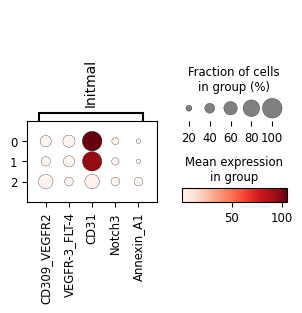

In [90]:
sc.pl.dotplot(
    cite_ec,
    groupby="leiden",
    var_names=marker_genes_in_data_cite,
    #standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [20]:
corrected_annotation = {
    "0": "pro angiogenic", # : venous origin", 
    "1": "EndoMT", # : arterial origin",
    "2": "Undefined"
}
adata_ec.obs["cell_type_level2"] = adata_ec.obs.leiden.map(corrected_annotation)

In [21]:
adata_ec.write("LarsJessi_ec_harm-annotlevel2.h5ad")

In [ ]:
#revision 2 (not reflected in outputs of this notebook)
adata_ec = sc.read_h5ad("LarsJessi_ec_harm-annotlevel2.h5ad")
proangio = adata_ec[adata_ec.obs["cell_type_level2"] == "pro angiogenic"]
sc.pp.neighbors(proangio, use_rep="Harmony")
sc.tl.umap(proangio)
sc.tl.leiden(proangio, resolution = 0.3)
ec_subtypes = {

    "Proangiogenic": ["ACKR1", "AQP1", "FABP4", "CXCL12"],
    "EndoMT": ["COL1A2", "FN1", "ACTA2", "SNAI1", "SNAI2"],
    "Arterial ECs": ["GJ4", "GJ5", "GATA2", "MECOM", "GJA4", "GJA5"],
    "Venous ECs": ["ACKR1", "NR2F2"],

    "EC": ["PECAM1", "VWF"]
}

level2_marker = {
    "ECs": ec_subtypes
}

marker_genes_in_data = {}
for celltype in level2_marker["ECs"]:
    marker_genes_in_data[celltype] = list(set(level2_marker["ECs"][celltype]).intersection(proangio.var_names))
    print(celltype, len(set(level2_marker["ECs"][celltype]).intersection(proangio.var_names))/len(level2_marker["ECs"][celltype]))
    print("not included: ", set(level2_marker["ECs"][celltype]).difference(proangio.var_names))

sc.pl.dotplot(
    proangio,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale=None,  # standard scale: normalize each gene to range from 0 to 1
    save = "proangio-sub-rev2.pdf"
)

corrected_annotation = {
    "0": "EC", 
    "1": "Pro-Angiogenic EC",
    "2": "EC",
    "3": "EC",
    "4": "EC",
    "5": "EC",
    "6": "EC",
    
}
proangio.obs["cell_type_level2"] = proangio.obs.leiden.map(corrected_annotation)
d = {'barcode': proangio.obs.index.values, 'new_ct': proangio.obs["cell_type_level2"].values}
df = pd.DataFrame(data=d)
df.to_csv("revision2_normalEC_mapping.csv")

In [ ]:
# plots for suppl figure

In [26]:
adata_ec = sc.read_h5ad("LarsJessi_ec_harm-annotlevel2.h5ad")

In [ ]:
mapping = pd.read_csv("revision2_normalEC_mapping.csv")
mapping_idx = mapping.set_index('barcode')['new_ct']
adata_ec.obs['cell_type_level2'] = adata_ec.obs['cell_type_level2'].astype(str)
adata_ec.obs['cell_type_level2'].update(mapping_idx)
adata_ec.obs['cell_type_level2'] = adata_ec.obs['cell_type_level2'].astype('category')

In [27]:
# For categorical columns:
adata_ec.obs["dataset"] = adata_ec.obs["dataset"].cat.rename_categories({"Roche": "Pauli"})
adata_ec.obs["cell_type_level2"] = adata_ec.obs["cell_type_level2"].cat.rename_categories(
    {"pro angiogenic": "Pro-Angiogenic EC", "EndoMT": "EndoMT EC"}
)

In [ ]:
color_palette_level2 = {
    'B cell': '#2ca02c',                       # green

    'CD4 T cell': '#6495ED',                   # Cornflower Blue
    'CD8 T cell': '#0047AB',                   # Cobalt Blue

    'EndoMT EC': '#FFD700',                    # Gold
    'Pro-Angiogenic EC': '#ED9121',            # Carrot Orange
    'EC': 'yellow',                            # Yellow

    'Fibroblast': '#e377c2',                   # bright pink
    'Fibromyocyte': '#f7b6d2',                 # pastel pink
    'Smooth Muscle Cell': '#7b4173',           # deeper purple

    'Other Macrophage': '#ece2d0',              # very light brown
    'TREM2+/Foamy Macrophage': '#c4a484',       # light tan-brown
    'HMOX1+ Macrophage': '#bf9b7a',             # medium brown
    'Inflammatory Macrophage': '#8b4513',       # saddle brown
    'PLIN2+/TREM1+ Macrophage': '#5b3a29',      # dark brown

    'Mast cell': '#d62728',                    # red

    'Monocyte': '#c7c7c7',                     # lighter gray
    'Neutrophil': '#17becf',                   # teal

    'NK cell': '#98df8a',                      # light green

    'Plasma cell': '#9467bd',                  # muted purple

    'Conventional dendritic cell 1': '#d4b9da',  # light violet
    'Conventional dendritic cell 2': '#807dba',  # medium violet
    'Plasmacytoid dendritic cell': '#4a1486',     # deep violet
    'Undefined': 'black'
}
# Define a new color palette for the datasets
origin_colors = {
    "Alsaigh": "#1E73BE",  # Blue
    "Chowdhury": "#FF7F00",  # Orange
    "Dib": "#228B22",  # Green
    "Emoto": "#D62728",  # Red
    "Fernandez": "#9467BD",  # Purple
    "Jaiswal": "#8B4513",  # Brown
    "Pan": "#FF69B4",  # Pink
    "Pauli": "#BDB76B",  # Olive
    "Slysz": "#00CED1",  # Turquoise
    "Slysz_femoral": "#ADD8E6",  # Light Blue
    "Wirka": "#FFB347",  # Peach
    "Bashore": "#FFD700"  # Gold (distinct yellow)
}

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_ac

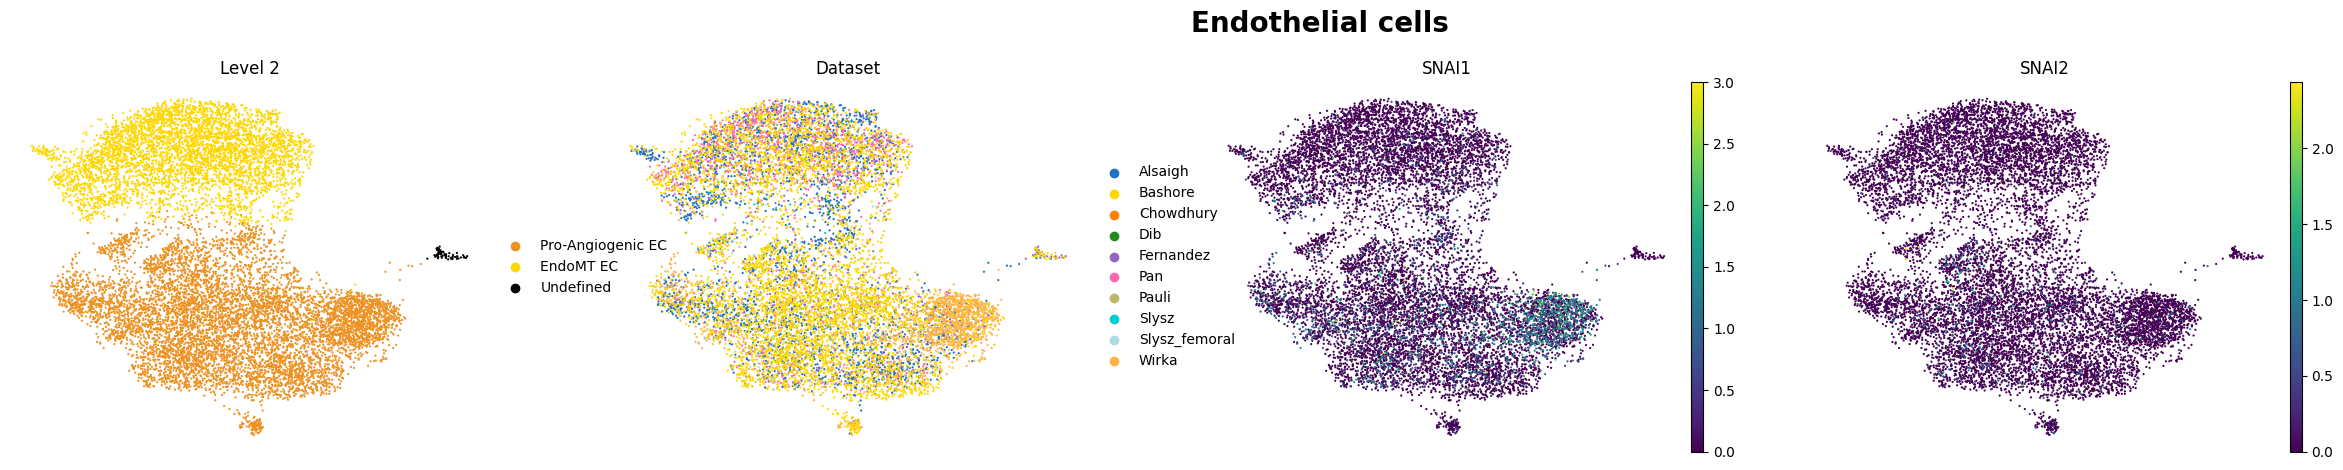

In [33]:
# Get the actual categories present in your data
categories = adata_ec.obs['cell_type_level2'].cat.categories

# Create a list of colors in the exact order of the categories
adata_ec.uns['cell_type_level2_colors'] = [color_palette_level2[cat] for cat in categories if cat in color_palette_level2]
# For 'dataset', create a list of colors from origin_mapping_dict in the correct category order:

adata_ec.uns['dataset_colors'] = [origin_colors[ds] for ds in adata_ec.obs['dataset'].cat.categories]

fig = sc.pl.umap(
    adata_ec, 
    color=['cell_type_level2', 'dataset', 'SNAI1', 'SNAI2'],
    ncols=4,
    frameon=False,
    title=["Level 2", "Dataset", "SNAI1", "SNAI2"],  # Custom titles for each subplot
    show=False,
    return_fig=True
)

# Add a main title above all subplots, larger, bold, and centered
fig.suptitle("Endothelial cells", y=1.05, fontsize=20, fontweight='bold', ha='center')

fig.tight_layout()
plt.savefig("figures/EC_level2_suppl.pdf")

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No dat

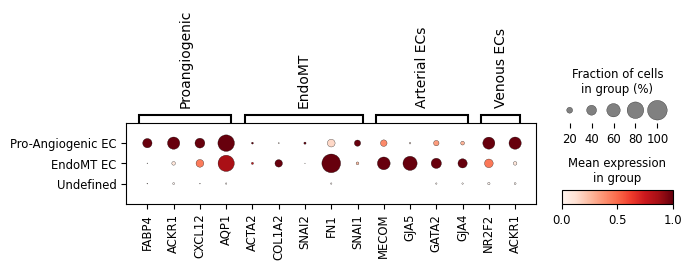

In [36]:
sc.pl.dotplot(
    adata_ec,
    groupby="cell_type_level2",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    save = "EC_level2_suppl.pdf"
)

# Macrophages

In [22]:
input_groups, data_mat, adata_out = normalize_subset_first(adata_all, "Macrophage")

In [23]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In addition: Warning messages:
1: In (function (x, sizes, min.mean = NULL, positive = FALSE, scaling = NULL)  :
  encountered non-positive size factor estimates
2: In (function (x, sizes, min.mean = NULL, positive = FALSE, scaling = NULL)  :
  encountered non-positive size factor estimates
3: In (function (x, sizes, min.mean = NULL, positive = FALSE, scaling = NULL)  :
  encountered non-positive size factor estimates
4: In (function (x, sizes, min.mean = NULL, positive = FALSE, scaling = NULL)  :
  encountered non-positive size factor estimates


In [24]:
adata_macros = normalize_subset_second(adata_out, size_factors)

/tmp/ipykernel_3678200/2282018356.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_1.obs['size_factors'] = size_factors
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [25]:
adata_macros.obsm["Harmony"] = harmonize(adata_macros.obsm["X_pca"], adata_macros.obs, batch_key="dataset")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
Reach convergence after 7 iteration(s).


In [26]:
adata_macros.write("LarsJessi_macros_harm.h5ad")

In [27]:
adata_macros = sc.read_h5ad("LarsJessi_macros_harm.h5ad")

In [28]:
sc.pp.neighbors(adata_macros, use_rep="Harmony")
sc.tl.umap(adata_macros)

In [ ]:
adata_macros = sc.write("LarsJessi_macros_harm-annotlevel2.h5ad")

In [ ]:
#reannotate

In [2]:
adata_macros = sc.read_h5ad("LarsJessi_macros_harm-annotlevel2.h5ad")

In [39]:

macros_subtypes = {
    "HMOX1hi": ["HMOX1", "FTL", "SLC40A1", "NUPR1", "SELENOP", "PRDX1", 
                          "CTSB", "CTSD", "LAMP2", "LGMN", "LIPA", "GPNMB", 
                          "APOC2", "APOE", "LRP1", "NPC2"],
    "Inflammation" : ["S100A8", "IL1B", "S100A9","IRF7", "IFITM3", "ISG15", "IFIT2", "LY6A"], # IFN + S100A8
    "PLIN2hi_TREM1hi": ["PLIN2", "TREM1", "TNF", "CEBPB", "IL1B", 
                             "CCL2", "CCL7", "CCL20", "CXCL1", "CXCL2", 
                             "CXCL3", "CXCL8"],
    "TREM2/Foamy": ["TREM2", "FABP4", "FABP5", "CD36", "MARCO"],
    "C1Q": ["C1QA", "C1QB", "C1QC"],
}


level2_marker = {
    "Macros": macros_subtypes
}

marker_genes_in_data_macros = {}
for celltype in level2_marker["Macros"]:
    marker_genes_in_data_macros[celltype] = list(set(level2_marker["Macros"][celltype]).intersection(adata_macros.var_names))
    print(celltype, len(set(level2_marker["Macros"][celltype]).intersection(adata_macros.var_names))/len(level2_marker["Macros"][celltype]))
    print("not included: ", set(level2_marker["Macros"][celltype]).difference(adata_macros.var_names))

HMOX1hi 1.0
not included:  set()
Inflammation 0.875
not included:  {'LY6A'}
PLIN2hi_TREM1hi 1.0
not included:  set()
TREM2/Foamy 1.0
not included:  set()
C1Q 1.0
not included:  set()


In [11]:
sc.tl.leiden(adata_macros, resolution = 0.6)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_ac

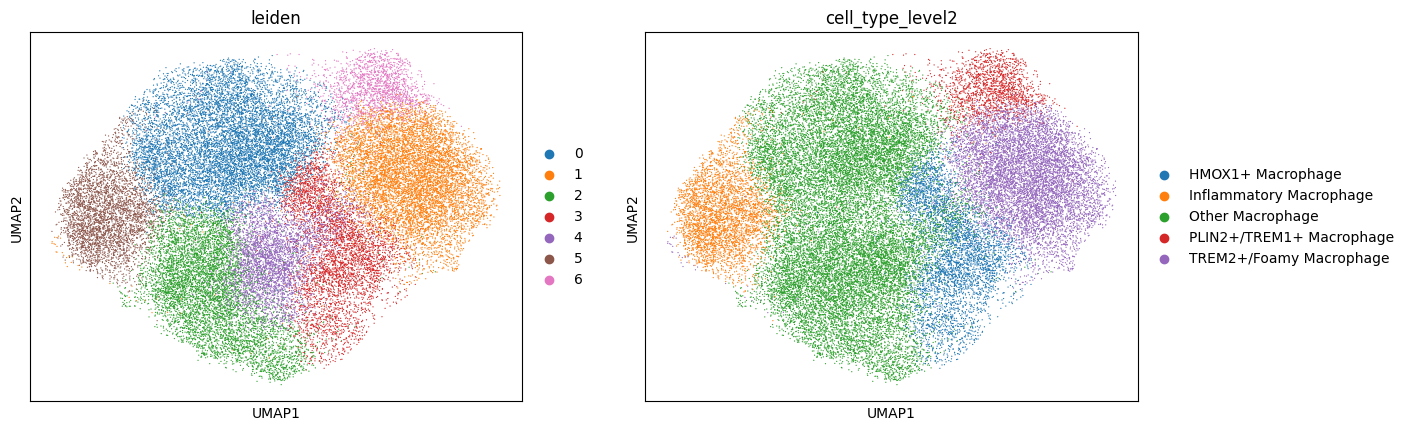

In [66]:
sc.pl.umap(adata_macros, color= ['leiden', "cell_type_level2"])

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No dat

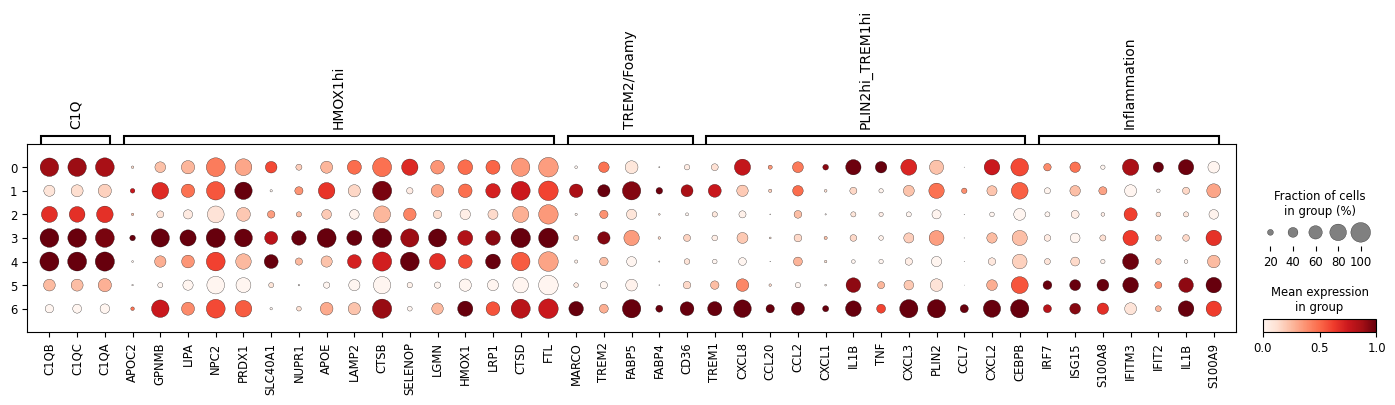

In [41]:
sc.pl.dotplot(
    adata_macros,
    groupby="leiden",
    var_names=marker_genes_in_data_macros,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [46]:
corrected_annotation = {
    "0": "Other Macrophage",
    "1": "TREM2+/Foamy Macrophage", 
    "2": "Other Macrophage", 
    "3": "HMOX1+ Macrophage", 
    "4": "Other Macrophage", 
    "5": "Inflammatory Macrophage",
    "6": "PLIN2+/TREM1+ Macrophage",
}
adata_macros.obs["cell_type_level2"] = adata_macros.obs.leiden.map(corrected_annotation)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No dat

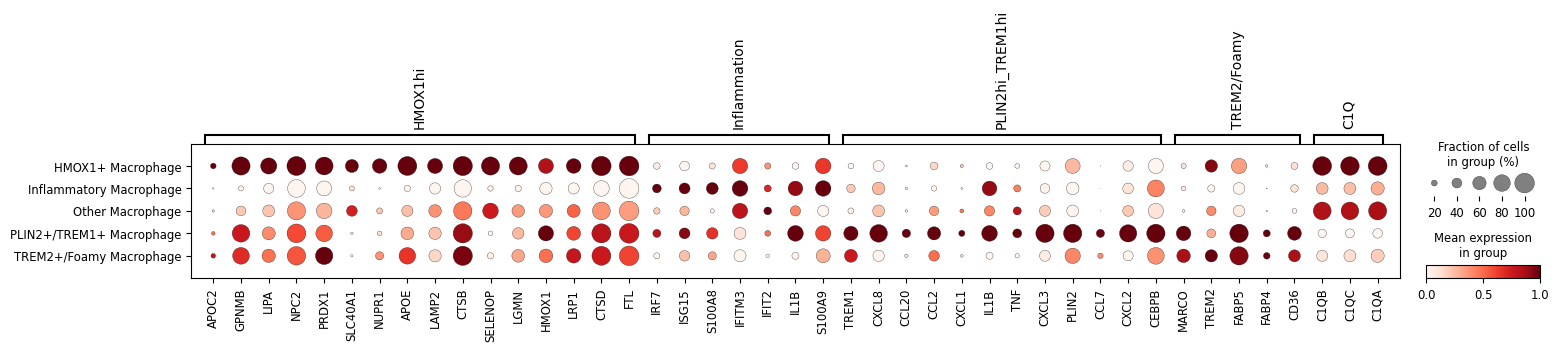

In [47]:
sc.pl.dotplot(
    adata_macros,
    groupby="cell_type_level2",
    var_names=marker_genes_in_data_macros,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [48]:
adata_macros.write("LarsJessi_macros_harm-annotlevel2-newDib+other.h5ad")

In [41]:
adata_macros = sc.read_h5ad("LarsJessi_macros_harm-annotlevel2-newDib+other.h5ad")

In [42]:
dataset_renaming_dict = {
    "Roche": "Pauli",
    "Emoto_ACS": "Emoto",
    "Emoto_SAP": "Emoto"
}

In [43]:
adata_macros.obs['dataset'] = adata_macros.obs['dataset'].map(lambda x: dataset_renaming_dict.get(x, x))

In [45]:
adata_macros.obs['dataset'] = adata_macros.obs['dataset'].astype('category')

In [61]:
# Get the actual categories present in your data
categories = adata_macros.obs['cell_type_level2'].cat.categories

# Create a list of colors in the exact order of the categories
adata_macros.uns['cell_type_level2_colors'] = [color_palette_level2[cat] for cat in categories if cat in color_palette_level2]
# For 'dataset', create a list of colors from origin_mapping_dict in the correct category order:

adata_macros.uns['dataset_colors'] = [origin_colors[ds] for ds in adata_macros.obs['dataset'].cat.categories]

sc.pl.umap(
    adata_macros,
    color=['cell_type_level2', 'dataset'],
    ncols=4,
    frameon=False,
    title=["Level 2", "Dataset"],
    show=False,
    wspace=0.4,
    save="Macros_level2_suppl.pdf"
)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_ac

[<Axes: title={'center': 'Level 2'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Dataset'}, xlabel='UMAP1', ylabel='UMAP2'>]

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No dat

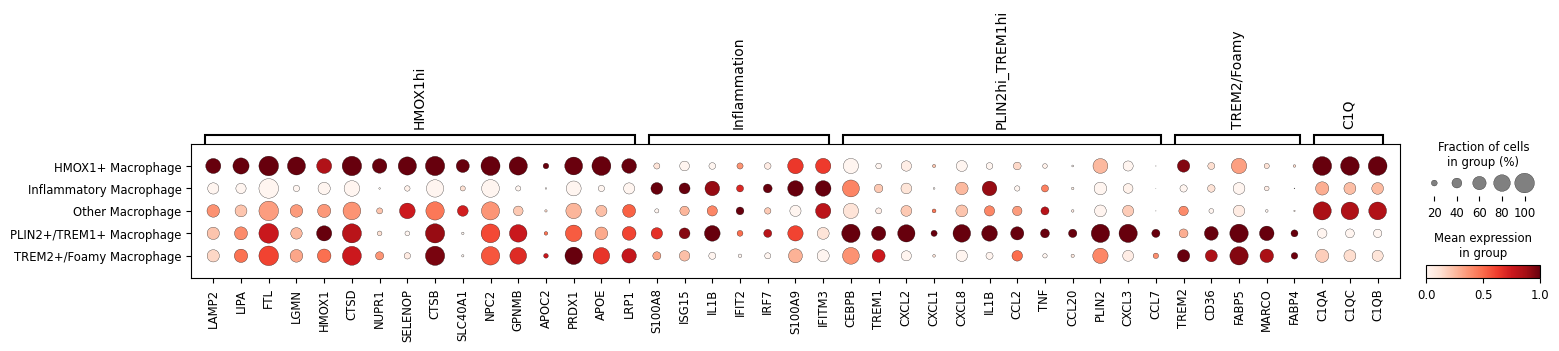

In [63]:
sc.pl.dotplot(
    adata_macros,
    groupby="cell_type_level2",
    var_names=marker_genes_in_data_macros,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    save = "Macros_level2_suppl.pdf"
)

# DCs

In [30]:
input_groups, data_mat, adata_out = normalize_subset_first(adata_all, "Dendritic cell")

In [31]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In addition: Warning message:
In (function (x, sizes, min.mean = NULL, positive = FALSE, scaling = NULL)  :
  encountered non-positive size factor estimates


In [32]:
adata_dc = normalize_subset_second(adata_out, size_factors)

/tmp/ipykernel_3678200/2282018356.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_1.obs['size_factors'] = size_factors
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [33]:
adata_dc.obsm["Harmony"] = harmonize(adata_dc.obsm["X_pca"], adata_dc.obs, batch_key="dataset")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


In [34]:
adata_dc.write("LarsJessi_dc_harm.h5ad")

In [35]:
sc.pp.neighbors(adata_dc, use_rep="Harmony")
sc.tl.umap(adata_dc)

In [52]:
sc.tl.leiden(adata_dc, resolution = 0.35)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_ac

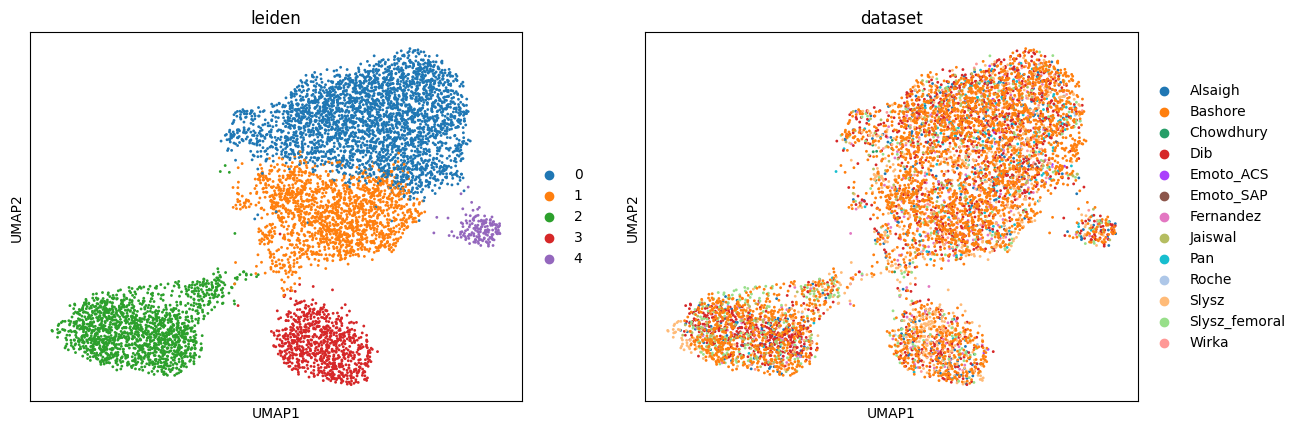

In [53]:
sc.pl.umap(adata_dc, color= ['leiden', "dataset"])

In [66]:
cdc1 = ["CLEC9A", "IRF8", "SNX3"]
cdc2 = ["CD1C", "CLEC10A", "FCER1A"]
pDClit = ["IRF7", "TLR7", "TLR9", "NRP1", "CLEC4C","IL3RA", "SCAMP5", "GZMB", "TCF4"] # https://pmc.ncbi.nlm.nih.gov/articles/PMC8984281/


dc_subtypes = {
    "cdc1": cdc1,
    "cdc2": cdc2,
    "pdc_lit": pDClit
}

level2_marker = {
    "DCs": dc_subtypes
}

marker_genes_in_data_dc = {}
for celltype in level2_marker["DCs"]:
    marker_genes_in_data_dc[celltype] = list(set(level2_marker["DCs"][celltype]).intersection(adata_dc.var_names))
    print(celltype, len(set(level2_marker["DCs"][celltype]).intersection(adata_dc.var_names))/len(level2_marker["DCs"][celltype]))
    print("not included: ", set(level2_marker["DCs"][celltype]).difference(adata_dc.var_names))

cdc1 1.0
not included:  set()
cdc2 1.0
not included:  set()
pdc_lit 0.8888888888888888
not included:  {'IL3RA'}


/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No dat

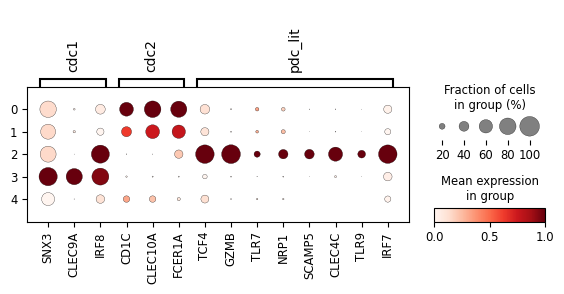

In [67]:
sc.pl.dotplot(
    adata_dc,
    groupby="leiden",
    var_names=marker_genes_in_data_dc,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [ ]:
cite_dc = subset_and_transfer_leiden(adata_dc, cite_adata)

In [ ]:
dc_subtypes_cite = {
    "pdc": ["CD47"],
    "cdc1": ["MmuIgG1", "RnorIgG1lambda"],
    "cdc2": ["CD110"]  
}

level2_marker_cite = {
    "DCs": dc_subtypes_cite
}

marker_genes_in_data_macros_cite = {}
for celltype in level2_marker["DCs"]:
    marker_genes_in_data_macros_cite[celltype] = list(set(level2_marker_cite["DCs"][celltype]).intersection(cite_dc.var_names))

In [56]:
corrected_annotation = {
    "0": "Conventional dendritic cell 2", 
    "1": "Conventional dendritic cell 2",
    "2": "Plasmacytoid dendritic cell",
    "3": "Conventional dendritic cell 1",
    "4": "Undefined"
}
adata_dc.obs["cell_type_level2"] = adata_dc.obs.leiden.map(corrected_annotation)

In [57]:
adata_dc.write("LarsJessi_dc_harm-annotlevel2.h5ad")

In [59]:
#Perform differential expression analysis
sc.tl.rank_genes_groups(
    adata_dc,
    groupby='cell_type_level2',    # The column in adata.obs that contains cluster labels
    groups=['Plasmacytoid dendritic cell'],        # The cluster(s) of interest; here, cluster '1'
    reference='rest',    # Compare against all other clusters
    method='t-test'      # Statistical test method (can be changed as needed)
)

# Get the names of the top 10 genes
top_genes = adata_dc.uns['rank_genes_groups']['names']['Plasmacytoid dendritic cell'][:20]

# Step 3: Print or further analyze the top genes
print("Top 20 DEGs in pDC cluster compared to the rest:")
for idx, gene in enumerate(top_genes, start=1):
    print(f"'{gene}',")

Top 20 DEGs in pDC cluster compared to the rest:
'GZMB',
'JCHAIN',
'IRF7',
'ITM2C',
'TCF4',
'PLAC8',
'C12orf75',
'LILRA4',
'TSPAN13',
'CLIC3',
'IGKC',
'MZB1',
'PLD4',
'SEC61B',
'DERL3',
'PPP1R14B',
'ALOX5AP',
'APP',
'CCDC50',
'UGCG',


In [64]:
adata_dc = sc.read_h5ad("LarsJessi_dc_harm-annotlevel2.h5ad")

In [65]:
dataset_renaming_dict = {
    "Roche": "Pauli",
    "Emoto_ACS": "Emoto",
    "Emoto_SAP": "Emoto"
}
adata_dc.obs['dataset'] = adata_dc.obs['dataset'].map(lambda x: dataset_renaming_dict.get(x, x))
adata_dc.obs['dataset'] = adata_dc.obs['dataset'].astype('category')

In [66]:
# Get the actual categories present in your data
categories = adata_dc.obs['cell_type_level2'].cat.categories

# Create a list of colors in the exact order of the categories
adata_dc.uns['cell_type_level2_colors'] = [color_palette_level2[cat] for cat in categories if cat in color_palette_level2]
# For 'dataset', create a list of colors from origin_mapping_dict in the correct category order:

adata_dc.uns['dataset_colors'] = [origin_colors[ds] for ds in adata_dc.obs['dataset'].cat.categories]

sc.pl.umap(
    adata_dc,
    color=['cell_type_level2', 'dataset'],
    ncols=4,
    frameon=False,
    title=["Level 2", "Dataset"],
    show=False,
    wspace=0.4,
    save="DC_level2_suppl.pdf"
)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_ac

[<Axes: title={'center': 'Level 2'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Dataset'}, xlabel='UMAP1', ylabel='UMAP2'>]

In [68]:
cdc1 = ["CLEC9A", "IRF8", "SNX3"]
cdc2 = ["CD1C", "CLEC10A", "FCER1A"]
pDC = ["TCF4", "GZMB", "TLR7", "TLR9", "NRP1", "SCAMP5", "CLEC4C", "IRF7"]



dc_subtypes = {
    "cdc1": cdc1,
    "cdc2": cdc2,
    "pDC": pDC,
    #"pdc_lit": pDClit
}

level2_marker = {
    "DCs": dc_subtypes
}

marker_genes_in_data_dc = {}
for celltype in level2_marker["DCs"]:
    marker_genes_in_data_dc[celltype] = list(set(level2_marker["DCs"][celltype]).intersection(adata_dc.var_names))
    print(celltype, len(set(level2_marker["DCs"][celltype]).intersection(adata_dc.var_names))/len(level2_marker["DCs"][celltype]))
    print("not included: ", set(level2_marker["DCs"][celltype]).difference(adata_dc.var_names))

cdc1 1.0
not included:  set()
cdc2 1.0
not included:  set()
pDC 1.0
not included:  set()


/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No dat

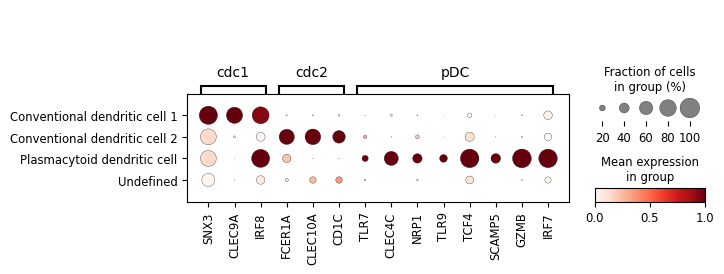

In [70]:
sc.pl.dotplot(
    adata_dc,
    groupby="cell_type_level2",
    var_names=marker_genes_in_data_dc,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    save="DC_level2_suppl.pdf"
)

# T cell

In [37]:
input_groups, data_mat, adata_out = normalize_subset_first(adata_all, "T cell")

In [38]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In addition: Warning messages:
1: In (function (x, sizes, min.mean = NULL, positive = FALSE, scaling = NULL)  :
  encountered non-positive size factor estimates
2: In .rescale_clusters(clust.profile, ref.col = ref.clust, min.mean = min.mean) :
  inter-cluster rescaling factor for cluster 46 is not strictly positive,
  reverting to the ratio of average library sizes


In [39]:
adata_tc = normalize_subset_second(adata_out, size_factors)

/tmp/ipykernel_3678200/2282018356.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_1.obs['size_factors'] = size_factors
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [40]:
adata_tc.obsm["Harmony"] = harmonize(adata_tc.obsm["X_pca"], adata_tc.obs, batch_key="dataset")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
Reach convergence after 5 iteration(s).


In [41]:
adata_tc.write("LarsJessi_tc_harm.h5ad")

In [42]:
adata_tc = sc.read_h5ad("LarsJessi_tc_harm.h5ad")

In [43]:
sc.pp.neighbors(adata_tc, use_rep="Harmony")
sc.tl.umap(adata_tc)

In [44]:
sc.tl.leiden(adata_tc, resolution = 0.2)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_ac

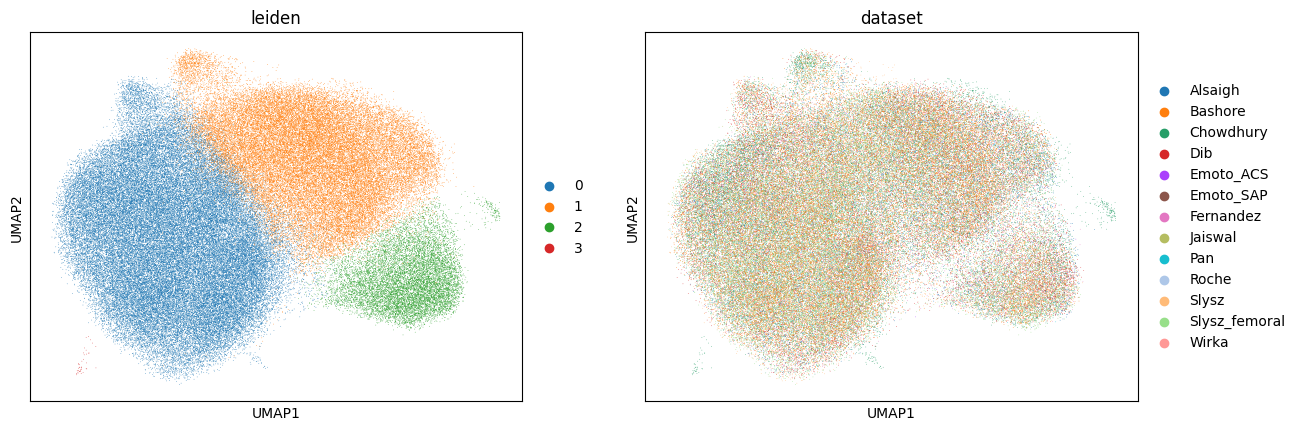

In [68]:
sc.pl.umap(adata_tc, color= ['leiden', "dataset"])

In [69]:
null = ["IL7R", "ANXA1", "FTH1", "CD4"]
one = ["CCL4L2", "CRTAM", "GZMK", "CCL4", "CD8A"]
two = ["GZMK", "CCL4", "CD8A", "GZMH"]
four = ["CXCL8", "IL1B", "LYZ", "HIST1HE1", "APOBEC3C"]
seven = ["TNFRSF4", "RTKN2", "BATF", "TNFRSF18", "TIGIT", "CD4", "FOXP3"]

tcells_subtypes = {
    "CD4+ TEff":null, 
    "CD8+ GZMK+":one,
    "CD8+ GZMH+":two,
    "unclear":four,
    "CD4+ Treg":seven
}

level2_marker = {
    "T cell": tcells_subtypes
}

marker_genes_in_data_tc = {}
for celltype in level2_marker["T cell"]:
    marker_genes_in_data_tc[celltype] = list(set(level2_marker["T cell"][celltype]).intersection(adata_tc.var_names))
    print(celltype, len(set(level2_marker["T cell"][celltype]).intersection(adata_tc.var_names))/len(level2_marker["T cell"][celltype]))
    print("not included: ", set(level2_marker["T cell"][celltype]).difference(adata_tc.var_names))

CD4+ TEff 1.0
not included:  set()
CD8+ GZMK+ 1.0
not included:  set()
CD8+ GZMH+ 1.0
not included:  set()
unclear 0.8
not included:  {'HIST1HE1'}
CD4+ Treg 1.0
not included:  set()


/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No dat

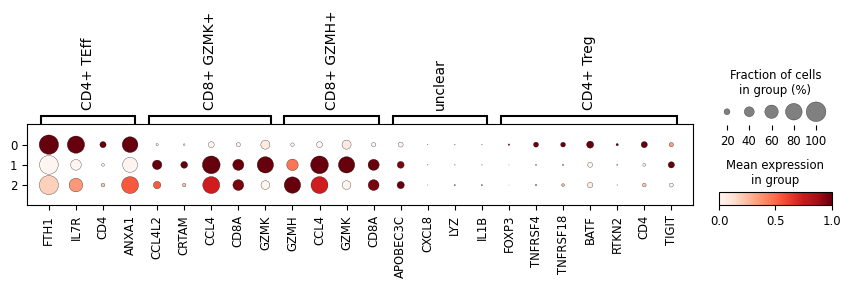

In [72]:
sc.pl.dotplot(
    adata_tc[adata_tc.obs["leiden"]!="3"],
    groupby="leiden",
    var_names=marker_genes_in_data_tc,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [73]:
cite_tc = subset_and_transfer_leiden(adata_tc, cite_adata)

In [74]:
tc_subtypes_cite = {
    "CD4": ["CD4", "CD3"],
    "CD8": ["CD8"],
    "other": ["CD3", "CD7", "CD2", "CD194_CCR4", "CD8"]  
}



level2_marker_cite = {
    "T cells": tc_subtypes_cite
}

marker_genes_in_data_tc_cite = {}
for celltype in level2_marker_cite["T cells"]:
    marker_genes_in_data_tc_cite[celltype] = list(set(level2_marker_cite["T cells"][celltype]).intersection(cite_tc.var_names))

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No dat

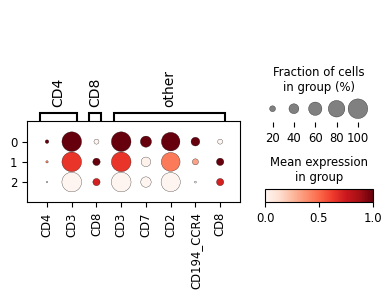

In [75]:
sc.pl.dotplot(
    cite_tc[cite_tc.obs["leiden"]!="3"],
    groupby="leiden",
    var_names=tc_subtypes_cite,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
)

In [76]:
corrected_annotation = {
    "0": "CD4 T cell", 
    "1": "CD8 T cell", 
    "2": "CD8 T cell",
    "3": "Undefined"
}
adata_tc.obs["cell_type_level2"] = adata_tc.obs.leiden.map(corrected_annotation)

In [77]:
adata_tc.write("LarsJessi_tc_harm-annotlevel2.h5ad")

In [71]:
adata_tc = sc.read_h5ad("LarsJessi_tc_harm-annotlevel2.h5ad")

In [72]:
dataset_renaming_dict = {
    "Roche": "Pauli",
    "Emoto_ACS": "Emoto",
    "Emoto_SAP": "Emoto"
}
adata_tc.obs['dataset'] = adata_tc.obs['dataset'].map(lambda x: dataset_renaming_dict.get(x, x))
adata_tc.obs['dataset'] = adata_tc.obs['dataset'].astype('category')

In [73]:
# Get the actual categories present in your data
categories = adata_tc.obs['cell_type_level2'].cat.categories

# Create a list of colors in the exact order of the categories
adata_tc.uns['cell_type_level2_colors'] = [color_palette_level2[cat] for cat in categories if cat in color_palette_level2]
# For 'dataset', create a list of colors from origin_mapping_dict in the correct category order:

adata_dc.uns['dataset_colors'] = [origin_colors[ds] for ds in adata_tc.obs['dataset'].cat.categories]

sc.pl.umap(
    adata_tc,
    color=['cell_type_level2', 'dataset'],
    ncols=4,
    frameon=False,
    title=["Level 2", "Dataset"],
    show=False,
    wspace=0.4,
    save="TC_level2_suppl.pdf"
)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_ac

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<Axes: title={'center': 'Level 2'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'Dataset'}, xlabel='UMAP1', ylabel='UMAP2'>]

In [82]:
null = ["IL7R", "ANXA1", "FTH1", "CD4", "TNFRSF4", "RTKN2", "BATF", "TNFRSF18", "TIGIT", "FOXP3"]
one = ["CCL4L2", "CRTAM", "GZMK", "CCL4", "CD8A", "GZMH"]
four = ["CXCL8", "IL1B", "LYZ", "HIST1HE1", "APOBEC3C"]

tcells_subtypes = {
    "CD4+":null, 
    "CD8+":one,
    #"unclear":four,
}

level2_marker = {
    "T cell": tcells_subtypes
}

marker_genes_in_data_tc = {}
for celltype in level2_marker["T cell"]:
    marker_genes_in_data_tc[celltype] = list(set(level2_marker["T cell"][celltype]).intersection(adata_tc.var_names))
    print(celltype, len(set(level2_marker["T cell"][celltype]).intersection(adata_tc.var_names))/len(level2_marker["T cell"][celltype]))
    print("not included: ", set(level2_marker["T cell"][celltype]).difference(adata_tc.var_names))

CD4+ 1.0
not included:  set()
CD8+ 1.0
not included:  set()


/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No dat

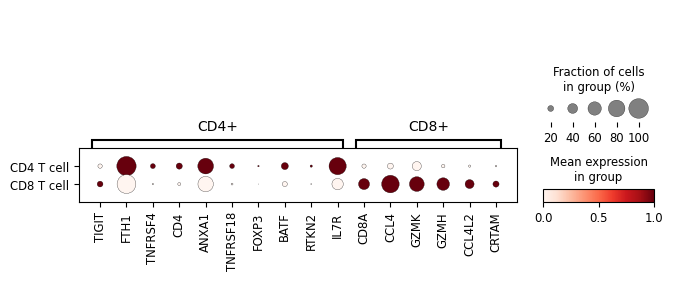

In [83]:
sc.pl.dotplot(
    adata_tc[adata_tc.obs["leiden"]!="3"], # Undefined cluster / leiden 3 probably cd4, but not sure, so removed
    groupby="cell_type_level2",
    var_names=marker_genes_in_data_tc,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    save="TC_level2_suppl.pdf"
)

# Prepare for BayesPrism

In [49]:
adata_all = sc.read_h5ad("Big-atlas-uncorrected_counts-corrected2-ensembleYES-noCITE.h5ad") # same as before but with ensembl_ids as vars and uncorrected counts

In [50]:
adata_all.obs

dataset  n_genes_by_counts  total_counts  \
car02_d_AAATGGATCGAGTGGA.1    Roche              647.0        1273.0   
car02_d_AAGGAATGTCGTTGGC.1    Roche             2881.0        9727.0   
car02_d_AATGGCTTCTTCCAGC.1    Roche             4906.0       43494.0   
car02_d_ACCTACCGTTTACTGG.1    Roche              335.0        8015.0   
car02_d_ACCTGAAGTCATCCCT.1    Roche             1113.0        2843.0   
...                             ...                ...           ...   
TTTGGTTGTTAGGCTT-1_12       Bashore             3987.0       15946.0   
TTTGTTGCAACTGCCG-1_12       Bashore             5827.0       27851.0   
TTTGTTGGTAGTCTGT-1_12       Bashore             3065.0       10611.0   
TTTGTTGGTTACCGTA-1_12       Bashore             2825.0        7735.0   
TTTGTTGTCAAGCCTA-1_12       Bashore             4476.0       18377.0   

                            total_counts_mt  pct_counts_mt      sample  \
car02_d_AAATGGATCGAGTGGA.1             78.0       6.127258     2_Roche   
car02_d_AAGGAATGTCGTTGGC.1           1564.0      16.078955     2_Roche   
car02_d_AATGGCTTCTTCCAGC.1           3031.0       6.968777     2_Roche   
car02_d_ACCTACCGTTTACTGG.1              3.0       0.037430     2_Roche   
car02_d_ACCTGAAGTCATCCCT.1            219.0       7.703130     2_Roche   
...                                     ...            ...         ...   
TTTGGTTGTTAGGCTT-1_12                 485.0       3.041515  12_Bashore   
TTTGTTGCAACTGCCG-1_12                 791.0       2.840113  12_Bashore   
TTTGTTGGTAGTCTGT-1_12                 578.0       5.447177  12_Bashore   
TTTGTTGGTTACCGTA-1_12                 629.0       8.131868  12_Bashore   
TTTGTTGTCAAGCCTA-1_12                1418.0       7.716167  12_Bashore   

                            n_genes  n_counts    cell_type_level1  
car02_d_AAATGGATCGAGTGGA.1      NaN       NaN              T cell  
car02_d_AAGGAATGTCGTTGGC.1      NaN       NaN          Macrophage  
car02_d_AATGGCTTCTTCCAGC.1      NaN       NaN          Macrophage  
car02_d_ACCTACCGTTTACTGG.1      NaN       NaN         Plasma cell  
car02_d_ACCTGAAGTCATCCCT.1      NaN       NaN           Mast cell  
...                             ...       ...                 ...  
TTTGGTTGTTAGGCTT-1_12        3987.0   15945.0        Fibromyocyte  
TTTGTTGCAACTGCCG-1_12        5827.0   27851.0                  EC  
TTTGTTGGTAGTCTGT-1_12        3065.0   10611.0  Smooth Muscle Cell  
TTTGTTGGTTACCGTA-1_12        2825.0    7735.0  Smooth Muscle Cell  
TTTGTTGTCAAGCCTA-1_12        4476.0   18377.0          Macrophage  

[259757 rows x 9 columns]

In [51]:
adata_tc = sc.read_h5ad("LarsJessi_tc_harm-annotlevel2.h5ad")
adata_macros = sc.read_h5ad("LarsJessi_macros_harm-annotlevel2-newDib+other.h5ad") # for "Big-atlas-uncorrected_counts-nootherlayers-corrected2-ensembleYES-noCITE-withlevel2-newDib+other.h5ad"
adata_dc = sc.read_h5ad("LarsJessi_dc_harm-annotlevel2.h5ad")
adata_ec = sc.read_h5ad("LarsJessi_ec_harm-annotlevel2.h5ad")

In [52]:
adata_list = [adata_tc, adata_macros, adata_dc, adata_ec]

In [53]:
adata_concat = anndata.concat(adata_list, join='outer', fill_value=0.0)

In [54]:
adata_concat

AnnData object with n_obs × n_vars = 179838 × 26023
    obs: 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample', 'n_genes', 'n_counts', 'cell_type_level1', 'size_factors', 'leiden', 'cell_type_level2'
    obsm: 'Harmony', 'X_pca', 'X_umap'

In [55]:
# Extract barcodes and cell_type_level2 values
barcodes = adata_concat.obs_names
cell_types_level2 = adata_concat.obs["cell_type_level2"]

# Create the mapping
mapping = dict(zip(barcodes, cell_types_level2))

In [56]:
# init new column
adata_all.obs["cell_type_level2"] = "no map"

In [57]:
# Update "cell_type_level2" in adata for matching barcodes
for barcode in adata_all.obs_names:
    if barcode in mapping:
        adata_all.obs.at[barcode, "cell_type_level2"] = mapping[barcode]

In [58]:
adata_all.obs["cell_type_level2"].value_counts()

cell_type_level2
no map                           79919
CD4 T cell                       69274
CD8 T cell                       53423
Other Macrophage                 20064
TREM2+/Foamy Macrophage           7873
pro angiogenic                    7563
Conventional dendritic cell 2     4694
HMOX1+ Macrophage                 4460
EndoMT                            4324
Inflammatory Macrophage           3733
PLIN2+/TREM1+ Macrophage          1755
Plasmacytoid dendritic cell       1604
Conventional dendritic cell 1      807
Undefined                          264
Name: count, dtype: int64

In [59]:
# Create a mask for rows where cell_type_level2 is "no map"
mask = adata_all.obs["cell_type_level2"] == "no map"

# Replace "no map" with the values from cell_type_level1
adata_all.obs.loc[mask, "cell_type_level2"] = adata_all.obs.loc[mask, "cell_type_level1"]

In [60]:
# rename
rename_dict = {
    "pro angiogenic": "Pro-Angiogenic EC",
    "EndoMT": "EndoMT EC"
}

In [61]:
adata_all.obs["cell_type_level2"] = adata_all.obs["cell_type_level2"].replace(rename_dict)

In [62]:
adata_all.obs["cell_type_level2"].value_counts()

cell_type_level2
CD4 T cell                       69274
CD8 T cell                       53423
Other Macrophage                 20064
Smooth Muscle Cell               16131
Monocyte                         13372
NK cell                          12500
B cell                           10255
Fibroblast                       10081
Fibromyocyte                      8263
TREM2+/Foamy Macrophage           7873
Pro-Angiogenic EC                 7563
Conventional dendritic cell 2     4694
HMOX1+ Macrophage                 4460
EndoMT EC                         4324
Neutrophil                        3868
Inflammatory Macrophage           3733
Mast cell                         2965
Plasma cell                       2484
PLIN2+/TREM1+ Macrophage          1755
Plasmacytoid dendritic cell       1604
Conventional dendritic cell 1      807
Undefined                          264
Name: count, dtype: int64

In [63]:
# remove Undefined
adata_final = adata_all[adata_all.obs["cell_type_level2"] != "Undefined"].copy()

In [64]:
adata_final.obs["cell_type_level2"].value_counts()

cell_type_level2
CD4 T cell                       69274
CD8 T cell                       53423
Other Macrophage                 20064
Smooth Muscle Cell               16131
Monocyte                         13372
NK cell                          12500
B cell                           10255
Fibroblast                       10081
Fibromyocyte                      8263
TREM2+/Foamy Macrophage           7873
Pro-Angiogenic EC                 7563
Conventional dendritic cell 2     4694
HMOX1+ Macrophage                 4460
EndoMT EC                         4324
Neutrophil                        3868
Inflammatory Macrophage           3733
Mast cell                         2965
Plasma cell                       2484
PLIN2+/TREM1+ Macrophage          1755
Plasmacytoid dendritic cell       1604
Conventional dendritic cell 1      807
Name: count, dtype: int64

In [65]:
adata_final.write("Big-atlas-uncorrected_counts-nootherlayers-corrected2-ensembleYES-noCITE-withlevel2-newDib+other.h5ad") # with ensembl_ids and new macro subtypes without c1q

In [46]:
adata_final.X.sum()

1363265513.0

In [47]:
adata_final.var

original_gene_names       ensembl_id     mt  \
ensembl_id                                                    
ENSG00000000003              TSPAN6  ENSG00000000003  False   
ENSG00000000005                TNMD  ENSG00000000005  False   
ENSG00000000419                DPM1  ENSG00000000419  False   
ENSG00000000457               SCYL3  ENSG00000000457  False   
ENSG00000000460            C1orf112  ENSG00000000460  False   
...                             ...              ...    ...   
ENSG00000288162          AL596442.4  ENSG00000288162  False   
ENSG00000288187          CU633906.5  ENSG00000288187  False   
ENSG00000288235             FAM106C  ENSG00000288235  False   
ENSG00000288253          AC010332.3  ENSG00000288253  False   
ENSG00000288398          AL109627.1  ENSG00000288398  False   

                 n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
ensembl_id                                                               
ENSG00000000003               3055     0.048229              96.271753   
ENSG00000000005                  5     0.000061              99.993898   
ENSG00000000419              14521     0.222279              82.278929   
ENSG00000000457               3850     0.050963              95.301555   
ENSG00000000460               1748     0.022943              97.866784   
...                            ...          ...                    ...   
ENSG00000288162                 18     0.000220              99.978033   
ENSG00000288187                151     0.001892              99.815723   
ENSG00000288235                 98     0.001196              99.880403   
ENSG00000288253                234     0.002941              99.714432   
ENSG00000288398                338     0.004210              99.587513   

                 total_counts  n_cells  
ensembl_id                              
ENSG00000000003        3952.0     2922  
ENSG00000000005           5.0        5  
ENSG00000000419       18214.0    14186  
ENSG00000000457        4176.0     3742  
ENSG00000000460        1880.0     1680  
...                       ...      ...  
ENSG00000288162          18.0       17  
ENSG00000288187         155.0      146  
ENSG00000288235          98.0       96  
ENSG00000288253         241.0      227  
ENSG00000288398         345.0      328  

[26023 rows x 8 columns]

In [ ]:
# revision2
adata = sc.read_h5ad("Big-atlas-uncorrected_counts-nootherlayers-corrected2-ensembleYES-noCITE-withlevel2-newDib+other.h5ad") 
mapping = pd.read_csv("revision2_normalEC_mapping.csv")
mapping_idx = mapping.set_index('barcode')['new_ct']
adata.obs['cell_type_level2'] = adata.obs['cell_type_level2'].astype(str)
adata.obs['cell_type_level2'].update(mapping_idx)
adata.obs['cell_type_level2'] = adata.obs['cell_type_level2'].astype('category')
adata.write("Big-atlas-uncorrected_counts-nootherlayers-corrected2-ensembleYES-noCITE-withlevel2-newDib+other-revision2-withnormalEC.h5ad") # with normal ECs

# Prepare for scPower

In [97]:
adata = sc.read_h5ad("Big-atlas-uncorrected_counts-nootherlayers-corrected2-ensembleYES-noCITE-withlevel2.h5ad") 

In [99]:
adata.var

original_gene_names       ensembl_id     mt  \
ensembl_id                                                    
ENSG00000000003              TSPAN6  ENSG00000000003  False   
ENSG00000000005                TNMD  ENSG00000000005  False   
ENSG00000000419                DPM1  ENSG00000000419  False   
ENSG00000000457               SCYL3  ENSG00000000457  False   
ENSG00000000460            C1orf112  ENSG00000000460  False   
...                             ...              ...    ...   
ENSG00000288162          AL596442.4  ENSG00000288162  False   
ENSG00000288187          CU633906.5  ENSG00000288187  False   
ENSG00000288235             FAM106C  ENSG00000288235  False   
ENSG00000288253          AC010332.3  ENSG00000288253  False   
ENSG00000288398          AL109627.1  ENSG00000288398  False   

                 n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
ensembl_id                                                               
ENSG00000000003               3055     0.048229              96.271753   
ENSG00000000005                  5     0.000061              99.993898   
ENSG00000000419              14521     0.222279              82.278929   
ENSG00000000457               3850     0.050963              95.301555   
ENSG00000000460               1748     0.022943              97.866784   
...                            ...          ...                    ...   
ENSG00000288162                 18     0.000220              99.978033   
ENSG00000288187                151     0.001892              99.815723   
ENSG00000288235                 98     0.001196              99.880403   
ENSG00000288253                234     0.002941              99.714432   
ENSG00000288398                338     0.004210              99.587513   

                 total_counts  n_cells  
ensembl_id                              
ENSG00000000003        3952.0     2922  
ENSG00000000005           5.0        5  
ENSG00000000419       18214.0    14186  
ENSG00000000457        4176.0     3742  
ENSG00000000460        1880.0     1680  
...                       ...      ...  
ENSG00000288162          18.0       17  
ENSG00000288187         155.0      146  
ENSG00000288235          98.0       96  
ENSG00000288253         241.0      227  
ENSG00000288398         345.0      328  

[26023 rows x 8 columns]

In [100]:
adata.var.index = adata.var['original_gene_names']

In [101]:
adata.write("Big-atlas-uncorrected_counts-nootherlayers-corrected2-ensembleNO-noCITE-withlevel2.h5ad") 

In [ ]:
adata = sc.read_h5ad("Big-atlas-uncorrected_counts-nootherlayers-corrected2-ensembleYES-noCITE-withlevel2.h5ad") # with ensembl_ids

In [10]:
adata[adata.obs["dataset"]=="Roche"].obs["cell_type_level1"].value_counts(normalize=True)

cell_type_level1
T cell                0.245075
Smooth Muscle Cell    0.163909
EC                    0.162333
Macrophage            0.151300
Fibromyocyte          0.059102
NK cell               0.054374
Fibroblast            0.053586
Monocyte              0.041765
Plasma cell           0.019701
Mast cell             0.015760
Dendritic cell        0.014184
B cell                0.010244
Neutrophil            0.008668
Name: proportion, dtype: float64

# Prepare Version for retraining on big atlas for automatic mapping

In [ ]:
# load final annotations

In [67]:
annot_big_atlas = sc.read_h5ad("Big-atlas-uncorrected_counts-nootherlayers-corrected2-ensembleYES-noCITE-withlevel2-newDib+other.h5ad") # from this script above in BayesPrism for level 2

In [68]:
annot_big_atlas

AnnData object with n_obs × n_vars = 259493 × 26023
    obs: 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample', 'n_genes', 'n_counts', 'cell_type_level1', 'cell_type_level2'
    var: 'original_gene_names', 'ensembl_id', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [69]:
annot_big_atlas.obs

dataset  n_genes_by_counts  total_counts  \
car02_d_AAATGGATCGAGTGGA.1    Roche              647.0        1273.0   
car02_d_AAGGAATGTCGTTGGC.1    Roche             2881.0        9727.0   
car02_d_AATGGCTTCTTCCAGC.1    Roche             4906.0       43494.0   
car02_d_ACCTACCGTTTACTGG.1    Roche              335.0        8015.0   
car02_d_ACCTGAAGTCATCCCT.1    Roche             1113.0        2843.0   
...                             ...                ...           ...   
TTTGGTTGTTAGGCTT-1_12       Bashore             3987.0       15946.0   
TTTGTTGCAACTGCCG-1_12       Bashore             5827.0       27851.0   
TTTGTTGGTAGTCTGT-1_12       Bashore             3065.0       10611.0   
TTTGTTGGTTACCGTA-1_12       Bashore             2825.0        7735.0   
TTTGTTGTCAAGCCTA-1_12       Bashore             4476.0       18377.0   

                            total_counts_mt  pct_counts_mt      sample  \
car02_d_AAATGGATCGAGTGGA.1             78.0       6.127258     2_Roche   
car02_d_AAGGAATGTCGTTGGC.1           1564.0      16.078955     2_Roche   
car02_d_AATGGCTTCTTCCAGC.1           3031.0       6.968777     2_Roche   
car02_d_ACCTACCGTTTACTGG.1              3.0       0.037430     2_Roche   
car02_d_ACCTGAAGTCATCCCT.1            219.0       7.703130     2_Roche   
...                                     ...            ...         ...   
TTTGGTTGTTAGGCTT-1_12                 485.0       3.041515  12_Bashore   
TTTGTTGCAACTGCCG-1_12                 791.0       2.840113  12_Bashore   
TTTGTTGGTAGTCTGT-1_12                 578.0       5.447177  12_Bashore   
TTTGTTGGTTACCGTA-1_12                 629.0       8.131868  12_Bashore   
TTTGTTGTCAAGCCTA-1_12                1418.0       7.716167  12_Bashore   

                            n_genes  n_counts    cell_type_level1  \
car02_d_AAATGGATCGAGTGGA.1      NaN       NaN              T cell   
car02_d_AAGGAATGTCGTTGGC.1      NaN       NaN          Macrophage   
car02_d_AATGGCTTCTTCCAGC.1      NaN       NaN          Macrophage   
car02_d_ACCTACCGTTTACTGG.1      NaN       NaN         Plasma cell   
car02_d_ACCTGAAGTCATCCCT.1      NaN       NaN           Mast cell   
...                             ...       ...                 ...   
TTTGGTTGTTAGGCTT-1_12        3987.0   15945.0        Fibromyocyte   
TTTGTTGCAACTGCCG-1_12        5827.0   27851.0                  EC   
TTTGTTGGTAGTCTGT-1_12        3065.0   10611.0  Smooth Muscle Cell   
TTTGTTGGTTACCGTA-1_12        2825.0    7735.0  Smooth Muscle Cell   
TTTGTTGTCAAGCCTA-1_12        4476.0   18377.0          Macrophage   

                                   cell_type_level2  
car02_d_AAATGGATCGAGTGGA.1               CD8 T cell  
car02_d_AAGGAATGTCGTTGGC.1         Other Macrophage  
car02_d_AATGGCTTCTTCCAGC.1  TREM2+/Foamy Macrophage  
car02_d_ACCTACCGTTTACTGG.1              Plasma cell  
car02_d_ACCTGAAGTCATCCCT.1                Mast cell  
...                                             ...  
TTTGGTTGTTAGGCTT-1_12                  Fibromyocyte  
TTTGTTGCAACTGCCG-1_12                     EndoMT EC  
TTTGTTGGTAGTCTGT-1_12            Smooth Muscle Cell  
TTTGTTGGTTACCGTA-1_12            Smooth Muscle Cell  
TTTGTTGTCAAGCCTA-1_12              Other Macrophage  

[259493 rows x 10 columns]

In [70]:
# Extract barcodes and cell_type_level2 and level1 values
barcodes = annot_big_atlas.obs_names
cell_types_level2 = annot_big_atlas.obs["cell_type_level2"]
cell_types_level1 = annot_big_atlas.obs["cell_type_level1"]

# Create the mapping
mapping1 = dict(zip(barcodes, cell_types_level1))
mapping2 = dict(zip(barcodes, cell_types_level2))

In [71]:
# Load atlas and bashore log normalized and hvg

In [72]:
ref = sc.read_h5ad("atlas_reference_hvg_nobashore_log1p.h5ad")

In [73]:
ref.X.sum()

39740683.477737814

In [74]:
ref.var

original_gene_names  highly_variable
ENSG00000000938                 FGR             True
ENSG00000000971                 CFH             True
ENSG00000002587              HS3ST1             True
ENSG00000002933            TMEM176A             True
ENSG00000003436                TFPI             True
...                             ...              ...
ENSG00000282988          AL031777.3             True
ENSG00000286887          AL355881.1             True
ENSG00000287190          AC239799.2             True
ENSG00000287535          AC009630.4             True
ENSG00000287979          AC253572.2             True

[2000 rows x 2 columns]

In [75]:
query = sc.read_h5ad("atlas_query_hvg_bashore_log1p.h5ad")

In [77]:
query.X.toarray()

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.2202086, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.5419008, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.4770864, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [78]:
query.var

Empty DataFrame
Columns: []
Index: [ENSG00000000938, ENSG00000000971, ENSG00000002587, ENSG00000002933, ENSG00000003436, ENSG00000004468, ENSG00000004776, ENSG00000004799, ENSG00000005020, ENSG00000005243, ENSG00000005844, ENSG00000006016, ENSG00000006327, ENSG00000006747, ENSG00000007264, ENSG00000007312, ENSG00000007350, ENSG00000007908, ENSG00000008394, ENSG00000008516, ENSG00000008517, ENSG00000009790, ENSG00000010278, ENSG00000010319, ENSG00000010327, ENSG00000010610, ENSG00000010671, ENSG00000010810, ENSG00000011198, ENSG00000011422, ENSG00000011465, ENSG00000011600, ENSG00000012124, ENSG00000012779, ENSG00000012817, ENSG00000013297, ENSG00000013725, ENSG00000015133, ENSG00000017427, ENSG00000018280, ENSG00000018408, ENSG00000019169, ENSG00000019582, ENSG00000019991, ENSG00000020633, ENSG00000022267, ENSG00000023445, ENSG00000025708, ENSG00000026297, ENSG00000026751, ENSG00000026950, ENSG00000027075, ENSG00000027869, ENSG00000028277, ENSG00000029559, ENSG00000030419, ENSG00000030582, ENSG00000034053, ENSG00000034677, ENSG00000035862, ENSG00000036448, ENSG00000038427, ENSG00000038945, ENSG00000039319, ENSG00000041353, ENSG00000041982, ENSG00000042493, ENSG00000042980, ENSG00000043462, ENSG00000046653, ENSG00000047346, ENSG00000047365, ENSG00000047457, ENSG00000047662, ENSG00000048462, ENSG00000049192, ENSG00000049247, ENSG00000049249, ENSG00000049323, ENSG00000049540, ENSG00000049768, ENSG00000050165, ENSG00000050730, ENSG00000051108, ENSG00000052795, ENSG00000054654, ENSG00000055163, ENSG00000057657, ENSG00000057704, ENSG00000059377, ENSG00000059728, ENSG00000059804, ENSG00000060138, ENSG00000060982, ENSG00000061656, ENSG00000062716, ENSG00000064012, ENSG00000064201, ENSG00000064205, ENSG00000064225, ...]

[2000 rows x 0 columns]

In [79]:
# Concatenate while preserving .var["ensembl_id"]
adata_concat = anndata.concat(
    [ref, query],
    join='inner',
    merge='first'  # or 'same', depending on your data consistency
)

/home/icb/korbinian.traeuble/miniconda3/envs/jupyter-experimental/lib/python3.10/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [80]:
adata_concat.obs_names_make_unique()

In [81]:
adata_concat

AnnData object with n_obs × n_vars = 261206 × 2000
    obs: 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample', 'n_genes', 'n_counts', 'size_factors', 'cell_type_level1'
    var: 'original_gene_names', 'highly_variable'
    varm: 'PCs'

In [82]:
adata_concat.var

original_gene_names  highly_variable
ENSG00000000938                 FGR             True
ENSG00000000971                 CFH             True
ENSG00000002587              HS3ST1             True
ENSG00000002933            TMEM176A             True
ENSG00000003436                TFPI             True
...                             ...              ...
ENSG00000282988          AL031777.3             True
ENSG00000286887          AL355881.1             True
ENSG00000287190          AC239799.2             True
ENSG00000287535          AC009630.4             True
ENSG00000287979          AC253572.2             True

[2000 rows x 2 columns]

In [83]:
# init new column
adata_concat.obs["cell_type_level1"] = "no map"
adata_concat.obs["cell_type_level2"] = "no map"

In [84]:
# Update "cell_type_level2" in adata for matching barcodes
for barcode in adata_concat.obs_names:
    if barcode in mapping1:
        adata_concat.obs.at[barcode, "cell_type_level1"] = mapping1[barcode]
        adata_concat.obs.at[barcode, "cell_type_level2"] = mapping2[barcode]

In [85]:
adata_concat.obs["cell_type_level1"].value_counts()

cell_type_level1
T cell                122697
Macrophage             37885
Smooth Muscle Cell     16131
Monocyte               13372
NK cell                12500
EC                     11887
B cell                 10255
Fibroblast             10081
Fibromyocyte            8263
Dendritic cell          7105
Neutrophil              3868
Mast cell               2965
Plasma cell             2484
no map                  1713
Name: count, dtype: int64

In [86]:
# remove no maps. these are cells that were removed in the annotation due to uncertainty for example.
adata_final = adata_concat[adata_concat.obs["cell_type_level2"] != "no map"].copy()

In [87]:
adata_final

AnnData object with n_obs × n_vars = 259493 × 2000
    obs: 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample', 'n_genes', 'n_counts', 'size_factors', 'cell_type_level1', 'cell_type_level2'
    var: 'original_gene_names', 'highly_variable'
    varm: 'PCs'

In [88]:
#adata_final.write("Big-Atlas-level12-log1p-hvg.h5ad") # used for level 1, can ignore level 2
adata_final.write("Big-Atlas-level122-log1p-hvg.h5ad") # used for level 2

In [ ]:
# revision2
adata = sc.read_h5ad("Big-Atlas-level122-log1p-hvg.h5ad")
mapping = pd.read_csv("revision2_normalEC_mapping.csv")
mapping_idx = mapping.set_index('barcode')['new_ct']
adata.obs['cell_type_level2'] = adata.obs['cell_type_level2'].astype(str)
adata.obs['cell_type_level2'].update(mapping_idx)
adata.obs['cell_type_level2'] = adata.obs['cell_type_level2'].astype('category')
adata.write("Big-Atlas-level122-log1p-hvg-rev2.h5ad")

# analysis of big atlas and plots

In [2]:
adata = sc.read_h5ad("Big-atlas-uncorrected_counts-nootherlayers-corrected2-ensembleYES-noCITE-withlevel2-newDib+other.h5ad")

In [90]:
adata.obs

dataset  n_genes_by_counts  total_counts  \
car02_d_AAATGGATCGAGTGGA.1    Roche              647.0        1273.0   
car02_d_AAGGAATGTCGTTGGC.1    Roche             2881.0        9727.0   
car02_d_AATGGCTTCTTCCAGC.1    Roche             4906.0       43494.0   
car02_d_ACCTACCGTTTACTGG.1    Roche              335.0        8015.0   
car02_d_ACCTGAAGTCATCCCT.1    Roche             1113.0        2843.0   
...                             ...                ...           ...   
TTTGGTTGTTAGGCTT-1_12       Bashore             3987.0       15946.0   
TTTGTTGCAACTGCCG-1_12       Bashore             5827.0       27851.0   
TTTGTTGGTAGTCTGT-1_12       Bashore             3065.0       10611.0   
TTTGTTGGTTACCGTA-1_12       Bashore             2825.0        7735.0   
TTTGTTGTCAAGCCTA-1_12       Bashore             4476.0       18377.0   

                            total_counts_mt  pct_counts_mt      sample  \
car02_d_AAATGGATCGAGTGGA.1             78.0       6.127258     2_Roche   
car02_d_AAGGAATGTCGTTGGC.1           1564.0      16.078955     2_Roche   
car02_d_AATGGCTTCTTCCAGC.1           3031.0       6.968777     2_Roche   
car02_d_ACCTACCGTTTACTGG.1              3.0       0.037430     2_Roche   
car02_d_ACCTGAAGTCATCCCT.1            219.0       7.703130     2_Roche   
...                                     ...            ...         ...   
TTTGGTTGTTAGGCTT-1_12                 485.0       3.041515  12_Bashore   
TTTGTTGCAACTGCCG-1_12                 791.0       2.840113  12_Bashore   
TTTGTTGGTAGTCTGT-1_12                 578.0       5.447177  12_Bashore   
TTTGTTGGTTACCGTA-1_12                 629.0       8.131868  12_Bashore   
TTTGTTGTCAAGCCTA-1_12                1418.0       7.716167  12_Bashore   

                            n_genes  n_counts    cell_type_level1  \
car02_d_AAATGGATCGAGTGGA.1      NaN       NaN              T cell   
car02_d_AAGGAATGTCGTTGGC.1      NaN       NaN          Macrophage   
car02_d_AATGGCTTCTTCCAGC.1      NaN       NaN          Macrophage   
car02_d_ACCTACCGTTTACTGG.1      NaN       NaN         Plasma cell   
car02_d_ACCTGAAGTCATCCCT.1      NaN       NaN           Mast cell   
...                             ...       ...                 ...   
TTTGGTTGTTAGGCTT-1_12        3987.0   15945.0        Fibromyocyte   
TTTGTTGCAACTGCCG-1_12        5827.0   27851.0                  EC   
TTTGTTGGTAGTCTGT-1_12        3065.0   10611.0  Smooth Muscle Cell   
TTTGTTGGTTACCGTA-1_12        2825.0    7735.0  Smooth Muscle Cell   
TTTGTTGTCAAGCCTA-1_12        4476.0   18377.0          Macrophage   

                                   cell_type_level2  
car02_d_AAATGGATCGAGTGGA.1               CD8 T cell  
car02_d_AAGGAATGTCGTTGGC.1         Other Macrophage  
car02_d_AATGGCTTCTTCCAGC.1  TREM2+/Foamy Macrophage  
car02_d_ACCTACCGTTTACTGG.1              Plasma cell  
car02_d_ACCTGAAGTCATCCCT.1                Mast cell  
...                                             ...  
TTTGGTTGTTAGGCTT-1_12                  Fibromyocyte  
TTTGTTGCAACTGCCG-1_12                     EndoMT EC  
TTTGTTGGTAGTCTGT-1_12            Smooth Muscle Cell  
TTTGTTGGTTACCGTA-1_12            Smooth Muscle Cell  
TTTGTTGTCAAGCCTA-1_12              Other Macrophage  

[259493 rows x 10 columns]

In [3]:
dataset_renaming_dict = {
    "Roche": "Pauli",
    "Emoto_ACS": "Emoto",
    "Emoto_SAP": "Emoto"
}

In [4]:
adata.obs['dataset'] = adata.obs['dataset'].map(lambda x: dataset_renaming_dict.get(x, x))

In [5]:
origin_mapping_dict = {
    'Pauli':"carotid",
    'Alsaigh':"carotid",
    'Fernandez':"carotid",
    'Wirka':"coronary",
    'Emoto':"coronary",
    'Chowdhury':"coronary",
    'Pan': "carotid",
    'Dib':"carotid",
    'Slysz':"carotid",
    'Slysz_femoral':"femoral",
    'Jaiswal':"carotid",
    'Bashore':"carotid"
}

In [6]:
adata.obs['origin'] = adata.obs['dataset'].map(origin_mapping_dict).fillna("no map")

In [7]:
adata.obs

dataset  n_genes_by_counts  total_counts  \
car02_d_AAATGGATCGAGTGGA.1    Pauli              647.0        1273.0   
car02_d_AAGGAATGTCGTTGGC.1    Pauli             2881.0        9727.0   
car02_d_AATGGCTTCTTCCAGC.1    Pauli             4906.0       43494.0   
car02_d_ACCTACCGTTTACTGG.1    Pauli              335.0        8015.0   
car02_d_ACCTGAAGTCATCCCT.1    Pauli             1113.0        2843.0   
...                             ...                ...           ...   
TTTGGTTGTTAGGCTT-1_12       Bashore             3987.0       15946.0   
TTTGTTGCAACTGCCG-1_12       Bashore             5827.0       27851.0   
TTTGTTGGTAGTCTGT-1_12       Bashore             3065.0       10611.0   
TTTGTTGGTTACCGTA-1_12       Bashore             2825.0        7735.0   
TTTGTTGTCAAGCCTA-1_12       Bashore             4476.0       18377.0   

                            total_counts_mt  pct_counts_mt      sample  \
car02_d_AAATGGATCGAGTGGA.1             78.0       6.127258     2_Roche   
car02_d_AAGGAATGTCGTTGGC.1           1564.0      16.078955     2_Roche   
car02_d_AATGGCTTCTTCCAGC.1           3031.0       6.968777     2_Roche   
car02_d_ACCTACCGTTTACTGG.1              3.0       0.037430     2_Roche   
car02_d_ACCTGAAGTCATCCCT.1            219.0       7.703130     2_Roche   
...                                     ...            ...         ...   
TTTGGTTGTTAGGCTT-1_12                 485.0       3.041515  12_Bashore   
TTTGTTGCAACTGCCG-1_12                 791.0       2.840113  12_Bashore   
TTTGTTGGTAGTCTGT-1_12                 578.0       5.447177  12_Bashore   
TTTGTTGGTTACCGTA-1_12                 629.0       8.131868  12_Bashore   
TTTGTTGTCAAGCCTA-1_12                1418.0       7.716167  12_Bashore   

                            n_genes  n_counts    cell_type_level1  \
car02_d_AAATGGATCGAGTGGA.1      NaN       NaN              T cell   
car02_d_AAGGAATGTCGTTGGC.1      NaN       NaN          Macrophage   
car02_d_AATGGCTTCTTCCAGC.1      NaN       NaN          Macrophage   
car02_d_ACCTACCGTTTACTGG.1      NaN       NaN         Plasma cell   
car02_d_ACCTGAAGTCATCCCT.1      NaN       NaN           Mast cell   
...                             ...       ...                 ...   
TTTGGTTGTTAGGCTT-1_12        3987.0   15945.0        Fibromyocyte   
TTTGTTGCAACTGCCG-1_12        5827.0   27851.0                  EC   
TTTGTTGGTAGTCTGT-1_12        3065.0   10611.0  Smooth Muscle Cell   
TTTGTTGGTTACCGTA-1_12        2825.0    7735.0  Smooth Muscle Cell   
TTTGTTGTCAAGCCTA-1_12        4476.0   18377.0          Macrophage   

                                   cell_type_level2   origin  
car02_d_AAATGGATCGAGTGGA.1               CD8 T cell  carotid  
car02_d_AAGGAATGTCGTTGGC.1         Other Macrophage  carotid  
car02_d_AATGGCTTCTTCCAGC.1  TREM2+/Foamy Macrophage  carotid  
car02_d_ACCTACCGTTTACTGG.1              Plasma cell  carotid  
car02_d_ACCTGAAGTCATCCCT.1                Mast cell  carotid  
...                                             ...      ...  
TTTGGTTGTTAGGCTT-1_12                  Fibromyocyte  carotid  
TTTGTTGCAACTGCCG-1_12                     EndoMT EC  carotid  
TTTGTTGGTAGTCTGT-1_12            Smooth Muscle Cell  carotid  
TTTGTTGGTTACCGTA-1_12            Smooth Muscle Cell  carotid  
TTTGTTGTCAAGCCTA-1_12              Other Macrophage  carotid  

[259493 rows x 11 columns]

In [8]:
adata.obs['origin'].value_counts()

origin
carotid     188208
coronary     35914
femoral      35371
Name: count, dtype: int64

In [9]:
adata.obs['dataset'].value_counts()

dataset
Bashore          75582
Slysz_femoral    35371
Alsaigh          34626
Slysz            27245
Dib              25147
Chowdhury        22543
Wirka            11750
Fernandez         9935
Pan               8850
Jaiswal           5554
Emoto             1621
Pauli             1269
Name: count, dtype: int64

In [10]:
adata.obs['cell_type_level2'].value_counts()

cell_type_level2
CD4 T cell                       69274
CD8 T cell                       53423
Other Macrophage                 20064
Smooth Muscle Cell               16131
Monocyte                         13372
NK cell                          12500
B cell                           10255
Fibroblast                       10081
Fibromyocyte                      8263
TREM2+/Foamy Macrophage           7873
Pro-Angiogenic EC                 7563
Conventional dendritic cell 2     4694
HMOX1+ Macrophage                 4460
EndoMT EC                         4324
Neutrophil                        3868
Inflammatory Macrophage           3733
Mast cell                         2965
Plasma cell                       2484
PLIN2+/TREM1+ Macrophage          1755
Plasmacytoid dendritic cell       1604
Conventional dendritic cell 1      807
Name: count, dtype: int64